# Tuning XGB hyper-parameters

In [1]:
import pandas as pd
import numpy as np

import sklearn as sk
import sklearn.metrics as sk_mt
import sklearn.model_selection as sk_ms

import pickle as pkl

import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import os

import re

import typing as tp

Load the data, since there will be hyper-parameter tuning allow for train, test/eval datasets

In [2]:
TRAIN_TEST_PKL_PATH = '../prelims/train_test_data.pkl'

with open(TRAIN_TEST_PKL_PATH, 'rb') as fh: 
    data_dict = pkl.load(fh)
    
TRAIN_DF = data_dict['TRAIN_DF']
EVAL_DF = data_dict['TEST_DF']
#
TRAIN_LABEL_SRS = data_dict['TRAIN_LABEL']
EVAL_LABEL_SRS = data_dict['TEST_LABEL']

MODELS = {}
MODELS['vanilla'] = xgb.XGBClassifier()
MODELS['vanilla'].load_model('default_model.json')

Some inspiration is provied by [How to Configure the Gradient Boosting Algorithm](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/)

## Leaf weight distribution

How are the leaf weights distributed as a function of iteration (i.e. which tree it is)? Prepare a trial model

In [3]:
def weights_from_tree_str(
    tree_str: str
)->np.ndarray:
    """
    Given a string that enocdes the tree from xgboost, i.e. output from xgb_model.get_booster().get_dump()[0]
    extract all the leaf weights and return them as a string
    
    Arguments:
    ----------
        tree_str: string that encodes the tree
        
    Returns:
    --------
        np.ndarray list of leaf weights (in no particular order)
    """
    
    leaf_weights = []
    
    # extract using regular expressions
    for leaf_weight_str in re.findall('(?<=:leaf=)([\.0-9+-]*)', tree_str):
        leaf_weights.append(float(leaf_weight_str))
        
    return np.array(leaf_weights)

#########################

def leaf_quantiles_from_xgb(
    xgb_booster: xgb.core.Booster,
    requested_leaf_quantiles: tp.Optional[tp.Iterable[float]] = [0, 0.25, 0.5, 0.75, 1]
)->np.ndarray:
    """
    Given an xgb_booster use get_dump() to extract leaf weights for all trees. For each tree
    get the quantiles of leaf weights, as prescribed by requested_leaf_quantiles, return results
    for all trees as an N-by-K array where N is the number of trees and K is the number
    of quantiles
    
    Arguments:
    ---------
        xgb_booster:               booster for the model. needs to have get_dump() method
        requested_leaf_quantiles:  list of quantiles to compute for leaf weights
    
    Returns:
    --------
        by-K array where N is the number of trees and K is the number of quantiles
    """
    
    lq_list = []
    
    # go tree by tree and extract quantiles
    for i_tree, tree_str in enumerate(xgb_booster.get_dump()):
        leaf_weights = weights_from_tree_str(tree_str)

        lq_list.append(np.quantile(leaf_weights, requested_leaf_quantiles))
    
    return np.stack(lq_list, axis=0)

##############################

def plot_leaf_weight_evolution(
    tgt_ax:   mpl.axes.Axes,
    xgb_booster: xgb.core.Booster,
    requested_leaf_quantiles: tp.Optional[tp.Iterable[float]] = [0, 0.25, 0.5, 0.75, 1]
)->None:
    """
    Given target axis, booster and quantiles, plot all quantiles into the axis using leaf_quantiles_from_xgb
    
    Arguments:
    ----------
        tgt_ax:                    axis to plot into
        xgb_booster:               booster for the model. needs to have get_dump() method
        requested_leaf_quantiles:  list of quantiles to compute for leaf weights
    """
    
    leaf_stats = leaf_quantiles_from_xgb(xgb_booster, requested_leaf_quantiles)
    #
    
    for i_q, cur_q in enumerate(requested_leaf_quantiles):
        tgt_ax.plot(np.arange(leaf_stats.shape[0]), leaf_stats[:, i_q], '.', color=cm.tab10(i_q), label=f'q={cur_q:.3f}')
        
    tgt_ax.set_xlabel('Tree Index')
    tgt_ax.set_ylabel('Leaf weight')
    tgt_ax.grid()
    tgt_ax.legend()

Plot min/max/median of leaf weights

(-0.6, 0.6)

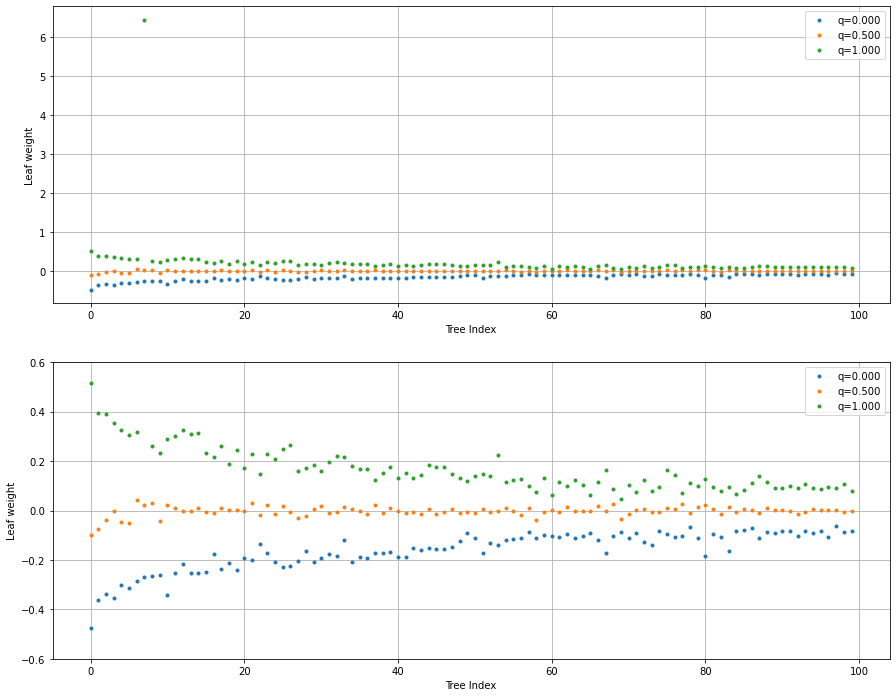

In [4]:
fig, ax = pp.subplots(2, 1, figsize=(15, 12))
#
plot_leaf_weight_evolution(ax[0], MODELS['vanilla'].get_booster(), [0, 0.5, 1])
#
plot_leaf_weight_evolution(ax[1], MODELS['vanilla'].get_booster(), [0, 0.5, 1])
ax[1].set_ylim([-0.6, 0.6])

## Learning rate

/home/cryo/anaconda3/envs/py36/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 1.0, 'LR=0.5')

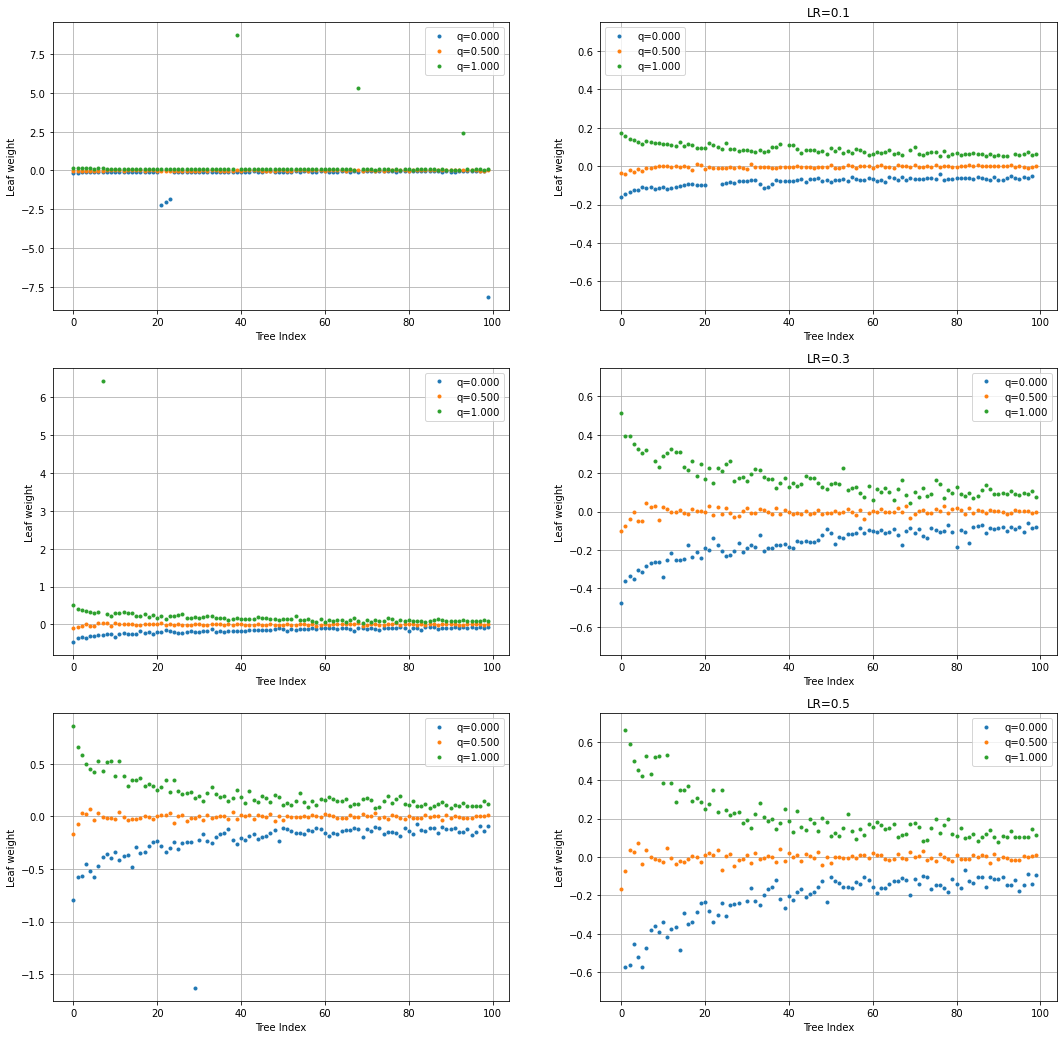

In [5]:
MODELS['learning_rate_0_1'] = xgb.XGBClassifier(learning_rate=0.1)
MODELS['learning_rate_0_1'].fit(TRAIN_DF, TRAIN_LABEL_SRS)
#
MODELS['learning_rate_0_3'] = xgb.XGBClassifier(learning_rate=0.3)
MODELS['learning_rate_0_3'].fit(TRAIN_DF, TRAIN_LABEL_SRS)
#
MODELS['learning_rate_0_5'] = xgb.XGBClassifier(learning_rate=0.5)
MODELS['learning_rate_0_5'].fit(TRAIN_DF, TRAIN_LABEL_SRS)
#

ylim = [-0.75, 0.75]

fig, ax = pp.subplots(3, 2, figsize=(18, 18))
#
plot_leaf_weight_evolution(ax[0, 0], MODELS['learning_rate_0_1'].get_booster(), [0, 0.5, 1])
plot_leaf_weight_evolution(ax[0, 1], MODELS['learning_rate_0_1'].get_booster(), [0, 0.5, 1])
ax[0, 1].set_ylim(ylim)
ax[0, 1].set_title('LR=0.1')
#
plot_leaf_weight_evolution(ax[1, 0], MODELS['learning_rate_0_3'].get_booster(), [0, 0.5, 1])
plot_leaf_weight_evolution(ax[1, 1], MODELS['learning_rate_0_3'].get_booster(), [0, 0.5, 1])
ax[1, 1].set_ylim(ylim)
ax[1, 1].set_title('LR=0.3')
#
plot_leaf_weight_evolution(ax[2, 0], MODELS['learning_rate_0_5'].get_booster(), [0, 0.5, 1])
plot_leaf_weight_evolution(ax[2, 1], MODELS['learning_rate_0_5'].get_booster(), [0, 0.5, 1])
ax[2, 1].set_ylim(ylim)
ax[2, 1].set_title('LR=0.5')
#

So, as one would expect, larger learning rate leads to steeper convergence of leaf weights to zero. Notable that larger learning rate leads to greater spread of leaf weights even at the first tree.

In [6]:
# will use prauc to score the model
def pr_auc_scorer(estimator, X, y):
    precision_curve, recall_curve, _ = sk_mt.precision_recall_curve(y_true=y, probas_pred=estimator.predict_proba(X)[:,1])
    i_order = np.argsort(recall_curve)
    
    return sk_mt.auc(recall_curve[i_order], precision_curve[i_order])

###########

param_grid = {
    'learning_rate': [0.1, 0.3, 0.6],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 7, 9],
    'min_child_weight': np.sqrt(len(TRAIN_LABEL_SRS)/sum(TRAIN_LABEL_SRS)) + np.array([0.0, 3.0]),
    'reg_lambda': [1, 2, 5],
    #
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
    'use_label_encoder': [False]
}

xgb_base_estimator = xgb.XGBClassifier()
grid_search_res = sk_ms.GridSearchCV(
    xgb_base_estimator, 
    param_grid, 
    cv=sk_ms.RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42),
    scoring=pr_auc_scorer,
    n_jobs=5
).fit(X=TRAIN_DF, y=TRAIN_LABEL_SRS)

MODELS['grid_selected'] = grid_search_res.best_estimator_

Compare the grid-search with vanilla hyper-parameters model

In [7]:
def plot_pr_curve(tgt_ax: mpl.axes.Axes, estimator: tp.Any, X: np.ndarray, y: np.ndarray, **kwargs)->None:
    """
    plot precision-recall curve into the given axis
    
    arguments:
    ----------
        tgt_ax: axis to plot into
        estimator: trained estimator with `predict_proba` method
        X: features
        y: labels
    """
    precision_curve, recall_curve, _ = sk_mt.precision_recall_curve(y_true=y, probas_pred=estimator.predict_proba(X)[:,1])
    i_order = np.argsort(recall_curve)
    
    tgt_ax.plot(recall_curve[i_order], precision_curve[i_order], **kwargs)

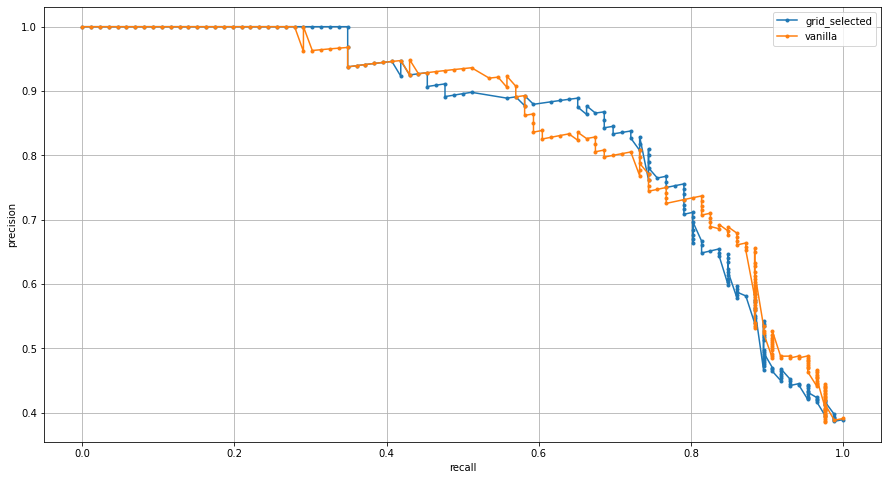

In [8]:
fig, ax = pp.subplots(figsize=(15, 8))

plot_pr_curve(ax, MODELS['grid_selected'], EVAL_DF.values, EVAL_LABEL_SRS.values, marker='.', label='grid_selected')
plot_pr_curve(ax, MODELS['vanilla'], EVAL_DF.values, EVAL_LABEL_SRS.values, marker='.', label='vanilla')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.grid()
ax.legend()

In [9]:
MODELS['grid_selected']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=4.61535599791501, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=5,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [10]:
MODELS['vanilla']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)